In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
import statistics
import copy
import math
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import gplearn
from pmdarima.arima import auto_arima
import pmdarima as pm
from gplearn.genetic import SymbolicRegressor


Temperature Dataset

In [2]:
temp = pd.read_csv(r"C:\Users\thewa\OneDrive\Documents\VSCode Modsim\VSCode Modsim Project 2\monthly_csv.csv")
temp = temp[temp["Source"] == "GISTEMP"].iloc[:444].reset_index(drop=True)

newdate = []
for date in temp["Date"]:
    if "/" in date:
        date = date.split("/")
        newdate.append((int(date[2])*12+int(date[0])-1) - (1980 * 12+1-1))
newmean = list(temp["Mean"])

newdate.reverse()
newmean.reverse()

temp["Mean"] = newmean
temp["Date"] = newdate

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=temp["Date"], y=temp["Mean"],
                    mode='markers+lines',
                    name='Actual'))

fig.update_layout(title = "Temp (months)")

fig.update_layout(height=400, width=800)

fig.show()

temp

,Source,Date,Mean
0,GISTEMP,0,0.30
1,GISTEMP,1,0.42
2,GISTEMP,2,0.29
3,GISTEMP,3,0.32
4,GISTEMP,4,0.34
...,...,...,...
439,GISTEMP,439,0.98
440,GISTEMP,440,0.87
441,GISTEMP,441,0.89
442,GISTEMP,442,0.93


Various Analyses, including ACF + ARIMA Fit

In [ ]:
testtemp = temp[temp['Date'] < 421]

fig = plt.figure(figsize=(12,8))

fig = sm.graphics.tsa.plot_acf(testtemp['Mean'].dropna())

fig.show()

fig = sm.graphics.tsa.plot_acf(testtemp['Mean'].diff().dropna())

fig.show()

fig = sm.graphics.tsa.plot_acf(testtemp['Mean'].diff().diff().dropna())

fig.show()

fig = sm.graphics.tsa.plot_pacf(testtemp['Mean'].dropna())

fig.show()

fig = sm.graphics.tsa.plot_pacf(testtemp['Mean'].diff().dropna())

fig.show()

fig = sm.graphics.tsa.plot_pacf(testtemp['Mean'].diff().diff().dropna())

fig.show()

fit1 = auto_arima(testtemp['Mean'], d=1, start_p = 0, D=12)
testtemp

In [4]:
fit1.to_dict()

{'pvalues': intercept    3.702308e-05
 ar.L1        2.099589e-03
 ar.L2        9.663815e-23
 ar.L3        8.735062e-03
 ma.L1        4.439411e-01
 ma.L2        3.488414e-11
 sigma2       2.213832e-51
 dtype: float64,
 'resid': 0      0.298678
 1      0.118678
 2     -0.082890
 3     -0.020028
 4      0.030022
          ...   
 416    0.153382
 417    0.030432
 418   -0.163515
 419    0.069172
 420    0.062200
 Length: 421, dtype: float64,
 'order': (3, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'oob': nan,
 'aic': -659.6543558963667,
 'aicc': -659.3831694556887,
 'bic': -631.3725729174248,
 'bse': intercept    0.000190
 ar.L1        0.140985
 ar.L2        0.066793
 ar.L3        0.070425
 ma.L1        0.133197
 ma.L2        0.132341
 sigma2       0.000774
 dtype: float64,
 'params': intercept    0.000784
 ar.L1       -0.433639
 ar.L2        0.655600
 ar.L3        0.184673
 ma.L1       -0.101969
 ma.L2       -0.876667
 sigma2       0.011670
 dtype: float64}

ARIMA anaylsis

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  421
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 336.827
Date:                Mon, 05 Dec 2022   AIC                           -659.654
Time:                        12:20:38   BIC                           -631.373
Sample:                             0   HQIC                          -648.476
                                - 421                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      4.125      0.000       0.000       0.001
ar.L1         -0.4336      0.141     -3.076      0.002      -0.710      -0.157
ar.L2          0.6556      0.067      9.815      0.0

RMSE: 1.2814274171901257


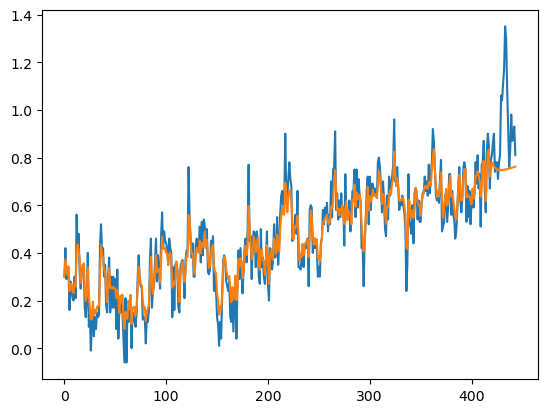

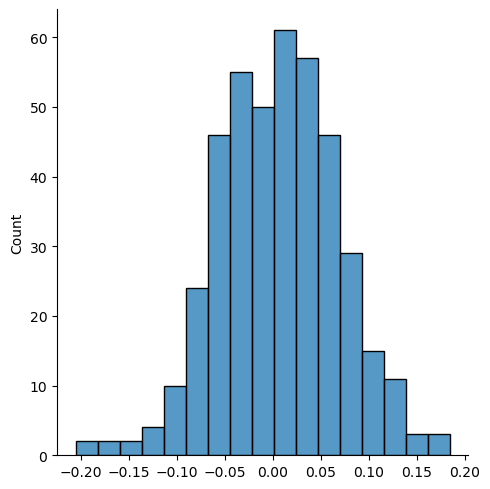

In [28]:
fit1 = auto_arima(testtemp['Mean'], d=1, D=12)

print(fit1.summary())

print(fit1.predict_in_sample())
print(fit1.to_dict())
#print(fit1.resid())

newlis = list(fit1.predict_in_sample())
newlis.extend(list(fit1.predict(n_periods = 24)))
newlis.pop(0)

xlist = [i for i in range(444)]

plt.plot(xlist, temp['Mean'])
plt.plot(xlist, newlis)

fig2 = make_subplots(rows=1, cols=1, subplot_titles=["Difference Plot"])

ydiff = np.asarray(newlis[:420]) - np.asarray(temp['Mean'][:420])
fig2.add_trace(go.Scatter(x = np.asarray(xlist[:420]), y = ydiff,
                    name='Differences'), row=1, col=1)

fig2.show()

sns.displot(ydiff)

print("RMSE: " + str(np.sqrt(sum(ydiff ** 2))))

Symbolic Regression

In [5]:
regress = SymbolicRegressor(population_size=100000,parsimony_coefficient=0.01,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos'))

regress.fit(np.array([i for i in range(421)]).reshape(-1, 1), np.array(testtemp['Mean']))

SymbolicRegressor(function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos'),
                  parsimony_coefficient=0.01, population_size=100000)

Symbolic Regression Analysis

In [16]:
ypred = regress.predict(np.reshape(np.array(xlist),(-1,1)))
print(regress._program)
print(np.array(testtemp['Mean']))
print(ypred)
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x = np.asarray(xlist), y = ypred,
                    name='Predicted'), row=1, col=1)
fig.add_trace(go.Scatter(x = np.asarray(xlist), y = temp['Mean'], name='Actual'), row=1, col=1)

fig.show()


mul(sub(add(cos(0.334), add(0.084, X0)), sin(add(X0, X0))), 0.002)
[ 0.3   0.42  0.29  0.32  0.34  0.16  0.28  0.24  0.21  0.2   0.3   0.21
  0.56  0.41  0.48  0.32  0.25  0.31  0.35  0.35  0.17  0.13  0.21  0.4
  0.09  0.14 -0.01  0.1   0.16  0.05  0.13  0.08  0.15  0.13  0.14  0.43
  0.52  0.4   0.42  0.3   0.35  0.18  0.15  0.3   0.38  0.15  0.3   0.17
  0.3   0.17  0.29  0.08  0.33  0.04  0.16  0.15  0.2   0.15  0.04 -0.06
  0.21 -0.06  0.17  0.11  0.17  0.17  0.    0.15  0.14  0.11  0.09  0.15
  0.3   0.39  0.29  0.26  0.26  0.12  0.13  0.12  0.02  0.14  0.11  0.16
  0.36  0.46  0.17  0.24  0.26  0.36  0.46  0.28  0.39  0.32  0.25  0.47
  0.57  0.42  0.49  0.45  0.44  0.42  0.35  0.46  0.42  0.4   0.13  0.34
  0.16  0.35  0.36  0.33  0.17  0.15  0.34  0.36  0.37  0.32  0.21  0.37
  0.41  0.41  0.76  0.55  0.46  0.38  0.44  0.3   0.3   0.43  0.46  0.42
  0.42  0.51  0.36  0.53  0.39  0.54  0.51  0.42  0.5   0.32  0.31  0.33
  0.45  0.42  0.47  0.24  0.32  0.24  0.13  0.1   0.01  0.

Ocean Temp Dataset

In [17]:
seatemp = pd.read_csv(r"C:\Users\thewa\OneDrive\Documents\VSCode Modsim\VSCode Modsim Project 2\sea-surface-temp_fig-1.csv")
seatemp = seatemp[seatemp["Year"] >= 1980][["Year", "Annual anomaly"]].reset_index(drop = True)


fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=seatemp["Year"], y=seatemp["Annual anomaly"],
                    mode='markers+lines'))

fig.update_layout(title = "Sea Temp (months)")

fig.update_layout(height=400, width=800)

fig.show()

seatemp

,Year,Annual anomaly
0,1980,0.066
1,1981,-0.006
2,1982,-0.006
3,1983,0.138
4,1984,-0.042
5,1985,-0.114
6,1986,-0.042
7,1987,0.210
8,1988,0.138
9,1989,0.066


Delayed Temp Model

In [23]:
pt = [newlis[9+12*i] for i in range(int(30))]
ptlag1 = np.concatenate((np.array([0]), np.array(pt[:-1])))
ptlag2 = np.concatenate((np.array([0]), np.array(ptlag1[:-1])))

model = linear_model.LinearRegression(normalize=True)

xval = []
for i in range(len(pt)):
    xval.append([pt[i], ptlag1[i], ptlag2[i]])
    
yval = seatemp["Annual anomaly"][:30]
model.fit(xval, yval)

m = list(model.coef_)
b = model.intercept_

print(model.coef_)
print(model.intercept_)

pt = [newlis[9+12*i] for i in range(int(35))]
ptlag1 = np.concatenate((np.array([0]), np.array(pt[:-1])))
ptlag2 = np.concatenate((np.array([0]), np.array(ptlag1[:-1])))

realy = seatemp["Annual anomaly"][:35]
predy = m[0] * np.array(pt) + m[1] * np.array(ptlag1) + m[2] * np.array(ptlag2) + b

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=seatemp["Year"], y=realy,
                    mode='markers+lines', name = "Actual"))

fig.add_trace(go.Scatter(x=seatemp["Year"], y=predy,
                    mode='markers+lines', name = "Pred"))

fig.update_layout(height=400, width=800)

fig.show()

print("RMSE: " + str(np.sqrt(sum((predy - realy) ** 2))))

[ 0.94477285  0.16361221 -0.25091967]
-0.16503648941267773


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





RMSE: 0.42161608366770287


Linear Regression

In [24]:
pt = [newlis[9+12*i] for i in range(int(30))]
model = linear_model.LinearRegression(normalize=True)
    
yval = seatemp["Annual anomaly"][:30]

model.fit(np.array(pt).reshape(-1, 1), yval)

m = list(model.coef_)
b = model.intercept_

print(model.coef_)
print(model.intercept_)

pt = [newlis[9+12*i] for i in range(int(35))]

realy = seatemp["Annual anomaly"][:35]
predy2 = m * np.array(pt) + b

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=seatemp["Year"], y=realy,
                    mode='markers+lines', name = "Actual"))

fig.add_trace(go.Scatter(x=seatemp["Year"], y=predy2,
                    mode='markers+lines', name = "Pred"))

fig.update_layout(height=400, width=800)

fig.show()

print("RMSE: " + str(np.sqrt(sum((predy2 - realy) ** 2))))

[0.87513423]
-0.16472165384695242


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





RMSE: 0.44223331952783307


Coral Survival Rate

In [10]:
r = 0.17
K = 63.85
P = 60

temp = list(fit1.predict(n_periods = 26 * 12))
temp = [temp[9+12*i] for i in range(int(26))][6:]
seatemp = m * np.array(temp) + b
seatemp = seatemp - list(seatemp)[0]

poplist = [P]
# P(t) = logistic growth (rP(t-1)(1-P(t-1)/K)) + P(t-1) * coral temp funx (1/2^(1/3x))

for i in range(20):
    pop = r * poplist[i] * (1 - poplist[i]/63.85) + 1/2 ** (1/3 * seatemp[i]) * poplist[i]
    poplist.append(pop)

xcoral = np.array([i for i in range(2020, 2041)])
ycoral = np.array(poplist)

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=xcoral, y=ycoral,
                    mode='markers+lines', name = "Predicted Coral"))

fig.update_layout(height=400, width=800, title = "Coral population oveseem r time")

fig.show()
